<a href="https://colab.research.google.com/github/syllerim/deep-learning-skin-diagnosis/blob/main/1_HAM10000_Tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 **Deep Learning - Diagnosis of Pigmented Skin Lesion using The HAM10000** 🧠

Use Google Colab

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 🧑‍🍳 **Set up paths to dataset files stored in Google Drive** 🗄️

In [15]:
# define base directory where the dataset files are stored in Google Drive
DATA_DIR = '/content/drive/MyDrive/KeepCoding/Bootcamp_AI/DeepLearning'

# metadata
PATH_METADATA = f'{DATA_DIR}/HAM10000_metadata.csv'
PATH_METADATA_DEV = f'{DATA_DIR}/HAM10000_metadata_dev.csv'
PATH_METADATA_TEST = f'{DATA_DIR}/HAM10000_metadata_test.csv'
PATH_METADATA_DEV2 = f'{DATA_DIR}/HAM10000_metadata_dev2.csv'
PATH_METADATA_TEST2 = f'{DATA_DIR}/HAM10000_metadata_test2.csv'

# images
PATH_IMAGES = f'{DATA_DIR}/hnmist_28_28_RGB.csv'
PATH_IMAGES_DEV = f'{DATA_DIR}/hnmist_28_28_RGB_dev.csv'
PATH_IMAGES_TEST = f'{DATA_DIR}/hnmist_28_28_RGB_test.csv'

# models
PATH_TABULAR_MODEL = f'{DATA_DIR}/HAM_tabular_model.keras'

# indexes
PATH_METADATA_TRAIN_IDX = f'{DATA_DIR}/HAM_metadata_train_idx.npy'
PATH_METADATA_VAL_IDX = f'{DATA_DIR}/HAM_metadata_val_idx.npy'

In [16]:
# import the main libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np

from keras.saving import save_model

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD

## 📂 **Load and explore datasets** 📥

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 💿 **Metadata**

In [19]:
# load metadata and images
df_metadata = pd.read_csv(PATH_METADATA, sep=',')

In [20]:
# check the shape
df_metadata.shape

(10015, 7)

In [21]:
# show first five rows
df_metadata.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp


In [22]:
# features information
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [23]:
df_metadata.isnull().sum().sort_values(ascending=False)

,0
age,57
image_id,0
lesion_id,0
dx,0
dx_type,0
sex,0
localization,0


In [24]:
# unique values for dx
df_metadata['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


📋 Diagnosis Meanings

|`dx`              | Description                                   |
|------------------|-----------------------------------------------|
| akiec            | Actinic keratoses / intraepithelial carcinoma |
| bcc              | Basal cell carcinoma                          |
| bkl              | Benign keratosis-like lesions                 |
| df               | Dermatofibroma                                |
| mel              | Melanoma (malignant)                          |
| nv               | Melanocytic nevi (benign)                     |
| vasc             | Vascular lesions                              |
|||

In [25]:
# unique values for dx_type
df_metadata['dx_type'].value_counts()

,count
dx_type,
histo,5340
follow_up,3704
consensus,902
confocal,69


In [26]:
# unique values for sex
df_metadata['sex'].value_counts()

,count
sex,
male,5406
female,4552
unknown,57


In [27]:
# unique values for localization
df_metadata['localization'].value_counts()

,count
localization,
back,2192
lower extremity,2077
trunk,1404
upper extremity,1118
abdomen,1022
face,745
chest,407
foot,319
unknown,234


In [28]:
# rows where 'age' is NaN
df_metadata[df_metadata['age'].isnull()]


,lesion_id,image_id,dx,dx_type,age,sex,localization
968,HAM_0001186,ISIC_0033391,bkl,consensus,NaN,unknown,unknown
969,HAM_0002660,ISIC_0033750,bkl,consensus,NaN,unknown,unknown
970,HAM_0000372,ISIC_0033685,bkl,consensus,NaN,unknown,unknown
971,HAM_0000948,ISIC_0033631,bkl,consensus,NaN,unknown,unknown
972,HAM_0000983,ISIC_0033490,bkl,consensus,NaN,unknown,unknown
973,HAM_0007281,ISIC_0034283,bkl,consensus,NaN,unknown,unknown
974,HAM_0001561,ISIC_0032740,bkl,consensus,NaN,unknown,unknown
975,HAM_0000825,ISIC_0034186,bkl,consensus,NaN,unknown,unknown
977,HAM_0006074,ISIC_0034252,bkl,consensus,NaN,unknown,unknown
978,HAM_0006074,ISIC_0033829,bkl,consensus,NaN,unknown,unknown


In [29]:
# rows where 'sex' is unknown.
df_metadata[df_metadata['sex'] == 'unknown']

,lesion_id,image_id,dx,dx_type,age,sex,localization
968,HAM_0001186,ISIC_0033391,bkl,consensus,NaN,unknown,unknown
969,HAM_0002660,ISIC_0033750,bkl,consensus,NaN,unknown,unknown
970,HAM_0000372,ISIC_0033685,bkl,consensus,NaN,unknown,unknown
971,HAM_0000948,ISIC_0033631,bkl,consensus,NaN,unknown,unknown
972,HAM_0000983,ISIC_0033490,bkl,consensus,NaN,unknown,unknown
973,HAM_0007281,ISIC_0034283,bkl,consensus,NaN,unknown,unknown
974,HAM_0001561,ISIC_0032740,bkl,consensus,NaN,unknown,unknown
975,HAM_0000825,ISIC_0034186,bkl,consensus,NaN,unknown,unknown
977,HAM_0006074,ISIC_0034252,bkl,consensus,NaN,unknown,unknown
978,HAM_0006074,ISIC_0033829,bkl,consensus,NaN,unknown,unknown


In [30]:
# resumen estadístico de todas las features, incluyendo variables numéricas y categóricas.
df_metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0000835,ISIC_0032258,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


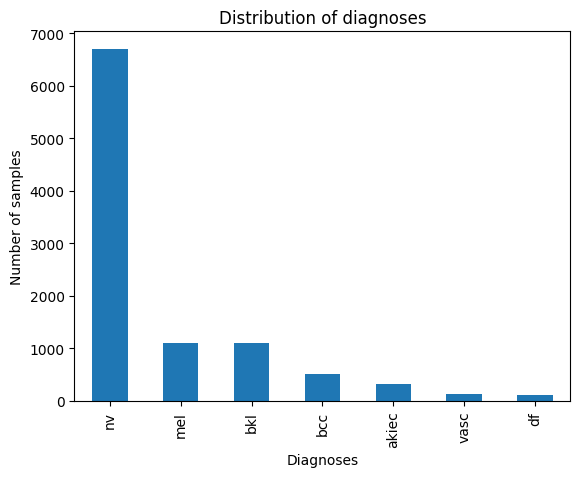

In [31]:
# plot class distribution
df_metadata['dx'].value_counts().plot(kind='bar', title='Distribution of diagnoses')
plt.xlabel('Diagnoses')
plt.ylabel('Number of samples')
plt.show()

### 🩻 **Images**

In [32]:
df_images = pd.read_csv(PATH_IMAGES, sep=',')

In [33]:
# check the shape
df_images.shape

(10015, 2352)

In [34]:
# show first five rows
df_images.head(2)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,pixel0040,pixel0041,pixel0042,pixel0043,pixel0044,pixel0045,pixel0046,pixel0047,pixel0048,pixel0049,pixel0050,pixel0051,pixel0052,pixel0053,pixel0054,pixel0055,pixel0056,pixel0057,pixel0058,pixel0059,pixel0060,pixel0061,pixel0062,pixel0063,pixel0064,pixel0065,pixel0066,pixel0067,pixel0068,pixel0069,pixel0070,pixel0071,pixel0072,pixel0073,pixel0074,pixel0075,pixel0076,pixel0077,pixel0078,pixel0079,pixel0080,pixel0081,pixel0082,pixel0083,pixel0084,pixel0085,pixel0086,pixel0087,pixel0088,pixel0089,pixel0090,pixel0091,pixel0092,pixel0093,pixel0094,pixel0095,pixel0096,pixel0097,pixel0098,pixel0099,pixel0100,pixel0101,pixel0102,pixel0103,pixel0104,pixel0105,pixel0106,pixel0107,pixel0108,pixel0109,pixel0110,pixel0111,pixel0112,pixel0113,pixel0114,pixel0115,pixel0116,pixel0117,pixel0118,pixel0119,pixel0120,pixel0121,pixel0122,pixel0123,pixel0124,pixel0125,pixel0126,pixel0127,pixel0128,pixel0129,pixel0130,pixel0131,pixel0132,pixel0133,pixel0134,pixel0135,pixel0136,pixel0137,pixel0138,pixel0139,pixel0140,pixel0141,pixel0142,pixel0143,pixel0144,pixel0145,pixel0146,pixel0147,pixel0148,pixel0149,pixel0150,pixel0151,pixel0152,pixel0153,pixel0154,pixel0155,pixel0156,pixel0157,pixel0158,pixel0159,pixel0160,pixel0161,pixel0162,pixel0163,pixel0164,pixel0165,pixel0166,pixel0167,pixel0168,pixel0169,pixel0170,pixel0171,pixel0172,pixel0173,pixel0174,pixel0175,pixel0176,pixel0177,pixel0178,pixel0179,pixel0180,pixel0181,pixel0182,pixel0183,pixel0184,pixel0185,pixel0186,pixel0187,pixel0188,pixel0189,pixel0190,pixel0191,pixel0192,pixel0193,pixel0194,pixel0195,pixel0196,pixel0197,pixel0198,pixel0199,pixel0200,pixel0201,pixel0202,pixel0203,pixel0204,pixel0205,pixel0206,pixel0207,pixel0208,pixel0209,pixel0210,pixel0211,pixel0212,pixel0213,pixel0214,pixel0215,pixel0216,pixel0217,pixel0218,pixel0219,pixel0220,pixel0221,pixel0222,pixel0223,pixel0224,pixel0225,pixel0226,pixel0227,pixel0228,pixel0229,pixel0230,pixel0231,pixel0232,pixel0233,pixel0234,pixel0235,pixel0236,pixel0237,pixel0238,pixel0239,pixel0240,pixel0241,pixel0242,pixel0243,pixel0244,pixel0245,pixel0246,pixel0247,pixel0248,pixel0249,pixel0250,pixel0251,pixel0252,pixel0253,pixel0254,pixel0255,pixel0256,pixel0257,pixel0258,pixel0259,pixel0260,pixel0261,pixel0262,pixel0263,pixel0264,pixel0265,pixel0266,pixel0267,pixel0268,pixel0269,pixel0270,pixel0271,pixel0272,pixel0273,pixel0274,pixel0275,pixel0276,pixel0277,pixel0278,pixel0279,pixel0280,pixel0281,pixel0282,pixel0283,pixel0284,pixel0285,pixel0286,pixel0287,pixel0288,pixel0289,pixel0290,pixel0291,pixel0292,pixel0293,pixel0294,pixel0295,pixel0296,pixel0297,pixel0298,pixel0299,pixel0300,pixel0301,pixel0302,pixel0303,pixel0304,pixel0305,pixel0306,pixel0307,pixel0308,pixel0309,pixel0310,pixel0311,pixel0312,pixel0313,pixel0314,pixel0315,pixel0316,pixel0317,pixel0318,pixel0319,pixel0320,pixel0321,pixel0322,pixel0323,pixel0324,pixel0325,pixel0326,pixel0327,pixel0328,pixel0329,pixel0330,pixel0331,pixel0332,pixel0333,pixel0334,pixel0335,pixel0336,pixel0337,pixel0338,pixel0339,pixel0340,pixel0341,pixel0342,pixel0343,pixel0344,pixel0345,pixel0346,pixel0347,pixel0348,pixel0349,pixel0350,pixel0351,pixel0352,pixel0353,pixel0354,pixel0355,pixel0356,pixel0357,pixel0358,pixel0359,pixel0360,pixel0361,pixel0362,pixel0363,pixel0364,pixel0365,pixel0366,pixel0367,pixel0368,pixel0369,pixel0370,pixel0371,pixel0372,pixel0373,pixel0374,pixel0375,pixel0376,pixel0377,pixel0378,pixel0379,pixel0380,pixel0381,pixel0382,pixel0383,pixel0384,pixel0385,pixel0386,pixel0387,pixel0388,pixel0389,pixel0390,pixel0391,pixel0392,pixel0393,pixel0394,pixel0395,pixel0396,pixel0397,pixel0398,pixel0399

## 🗑️ **Drop Data**

I decide to remove the columns `lesion_id` and `image_id` which are not useful for prediction.

In [35]:
df_metadata.drop(columns=['lesion_id', 'image_id'], inplace=True)

In [36]:
# verify drop
df_metadata.head(2)

,dx,dx_type,age,sex,localization
0,bkl,histo,80.0,male,scalp
1,bkl,histo,80.0,male,scalp


**Note:**
- Based on the metadata exploration, I decided to remove instances where age, sex, and localization contain no information.

- I also need to delete the instances for the same images in the images dataset.

In [37]:
# index of the rows to drop, based on the 3 conditions
indexes_to_drop = df_metadata[df_metadata['age'].isna() &(df_metadata['sex'] == 'unknown') & (df_metadata['localization'] == 'unknown')].index

# drop from metadata
df_metadata = df_metadata.drop(indexes_to_drop)

# drop from images
df_images = df_images.drop(indexes_to_drop)


In [38]:
df_metadata.shape[0]

9968

In [39]:
df_images.shape[0]

9968

## 🏗️ **Split Metadata into Development / Test** 🏠

For each dataset, `development` will be split into training and validation later.

In [40]:
# split based on index to use it in both datasets, metadata and images
dev_idx, test_idx = train_test_split(
    df_metadata.index,
    test_size=0.2,
    shuffle=True,
    random_state=0
)

**Metadata**

In [41]:
# split dataset into dev and test sets, then save the results to a file
metadata_dev = df_metadata.loc[dev_idx]
metadata_test = df_metadata.loc[test_idx]

metadata_dev.to_csv(PATH_METADATA_DEV, sep=',', decimal='.', index=False)
metadata_test.to_csv(PATH_METADATA_TEST, sep=',', decimal='.', index=False)

print(f'Shape metadata dev: {metadata_dev.shape}')
print(f'Shape metadata test: {metadata_test.shape}')

Shape metadata dev: (7974, 5)
Shape metadata test: (1994, 5)


**Images**

In [42]:
# split dataset into dev and test sets, then save the results to a file
images_dev = df_images.loc[dev_idx]
images_test = df_images.loc[test_idx]

images_dev.to_csv(PATH_IMAGES_DEV, sep=',', index=False)
images_test.to_csv(PATH_IMAGES_TEST, sep=',', index=False)

print(f'Shape images dev: {images_dev.shape}')
print(f'Shape images test: {images_test.shape}')

Shape images dev: (7974, 2352)
Shape images test: (1994, 2352)


In [43]:
# verify the datasets are alined
assert all(metadata_dev.index == images_dev.index)

## 👩🏻‍💻 **Assignment 1**

First let's start with the **Pre-Modeling Transformations**

### 🔁 **Transformations Metadata Dev**

#### 🩹 **Imputations**

In [44]:
# load only the development metadata and work with them
df_metadata_dev = pd.read_csv(PATH_METADATA_DEV, sep=',')
print(f'Shape metadata dev: {df_metadata_dev.shape}')

Shape metadata dev: (7974, 5)


In [45]:
# check null values for `Age`
df_metadata_dev.isnull().sum().sort_values(ascending=True)

,0
dx,0
dx_type,0
sex,0
localization,0
age,9


In [46]:
# impute missing age values using the median age grouped by sex and diagnosis
df_metadata_dev['age'] = df_metadata_dev.groupby(['sex', 'dx'])['age'].transform(lambda x: x.fillna(x.median()))

In [47]:
# verify results
df_metadata_dev.isnull().sum().sort_values(ascending=True)

,0
dx,0
dx_type,0
age,0
sex,0
localization,0


In [48]:
# check unknown values for sex
df_metadata_dev[df_metadata_dev['sex'] == 'unknown']

,dx,dx_type,age,sex,localization
1161,nv,histo,35.0,unknown,trunk
1395,nv,histo,45.0,unknown,abdomen
1976,nv,histo,35.0,unknown,trunk
2191,nv,histo,35.0,unknown,trunk
2238,nv,histo,0.0,unknown,back
2844,nv,histo,60.0,unknown,foot
4443,nv,histo,60.0,unknown,foot
4857,nv,histo,45.0,unknown,abdomen
6746,nv,histo,0.0,unknown,back


In [49]:
# impute unknown sex values using the mode grouped by diagnosis and localization
mode_sex_by_group = df_metadata_dev[df_metadata_dev['sex'] != 'unknown'] \
    .groupby(['dx', 'localization'])['sex'] \
    .agg(lambda x: x.mode().iloc[0])

# apply values
df_metadata_dev['sex'] = df_metadata_dev.apply(
    lambda row: mode_sex_by_group.get((row['dx'], row['localization']), 'unknown')
    if row['sex'] == 'unknown' else row['sex'],
    axis=1
)

In [50]:
# check unknown values for sex
df_metadata_dev['sex'].unique()

array(['female', 'male'], dtype=object)

In [51]:
# keep unknown values in localization as their own category
df_metadata_dev[df_metadata_dev['localization'] == 'unknown'].shape

(142, 5)

#### 🗂️ **Categorical Encoding - Normalization**

In [52]:
# encode sex as binary: female → 0, male → 1
df_metadata_dev['sex_binary'] = df_metadata_dev['sex'].map({'female': 0, 'male': 1})

In [53]:
# normalize age with MinMaxScaler: x_scaled = (x - min) / (max - min) → [0, 1]
df_metadata_dev['age_normalized'] = MinMaxScaler().fit_transform(df_metadata_dev[['age']])

In [54]:
# One-Hot-Encode for localization → separate binary columns for each class
df_onehot_loc = pd.get_dummies(df_metadata_dev['localization'], prefix='loc', dtype=int)
df_metadata_dev = pd.concat([df_metadata_dev, df_onehot_loc], axis=1)

In [55]:
# One-Hot-Encode for dx_type → separate binary columns for each class
df_onehot_dx_type = pd.get_dummies(df_metadata_dev['dx_type'], prefix='dxtype', dtype=int)
df_metadata_dev = pd.concat([df_metadata_dev, df_onehot_dx_type], axis=1)

In [56]:
# One-Hot-Encode for dx → separate binary columns for each class
df_onehot = pd.get_dummies(df_metadata_dev['dx'], prefix='dx', dtype=int)
df_metadata_dev = pd.concat([df_metadata_dev, df_onehot], axis=1)

In [57]:
# drop original columns
df_metadata_dev.drop(columns='sex', inplace=True)
df_metadata_dev.rename(columns={'sex_binary': 'sex'}, inplace=True)

df_metadata_dev.drop(columns='age', inplace=True)
df_metadata_dev.rename(columns={'age_normalized': 'age'}, inplace=True)

df_metadata_dev.drop(columns='localization', inplace=True)
df_metadata_dev.drop(columns='dx_type', inplace=True)
df_metadata_dev.drop(columns='dx', inplace=True)

In [58]:
df_metadata_dev.head(2)

,sex,age,loc_abdomen,loc_acral,loc_back,loc_chest,loc_ear,loc_face,loc_foot,loc_genital,loc_hand,loc_lower extremity,loc_neck,loc_scalp,loc_trunk,loc_unknown,loc_upper extremity,dxtype_confocal,dxtype_consensus,dxtype_follow_up,dxtype_histo,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc
0,0,0.529412,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,0.882353,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [59]:
# metadata dev transformed
df_metadata_dev.to_csv(PATH_METADATA_DEV2, sep=',', decimal='.', index=False)

### 🔁 **Transformations Metadata Test**

In [60]:
# load metadata test
df_metadata_test = pd.read_csv(PATH_METADATA_TEST, sep=',')
print(f'Shape metadata test: {df_metadata_test.shape}')

Shape metadata test: (1994, 5)


In [61]:
# impute missing age values using the median age grouped by sex and diagnosis
df_metadata_test['age'] = df_metadata_test.groupby(['sex', 'dx'])['age'].transform(lambda x: x.fillna(x.median()))

In [62]:
# impute unknown sex values using the mode grouped by diagnosis and localization
mode_sex_by_group_test = df_metadata_test[df_metadata_test['sex'] != 'unknown'] \
    .groupby(['dx', 'localization'])['sex'] \
    .agg(lambda x: x.mode().iloc[0])

# apply values
df_metadata_test['sex'] = df_metadata_test.apply(
    lambda row: mode_sex_by_group_test.get((row['dx'], row['localization']), 'unknown')
    if row['sex'] == 'unknown' else row['sex'],
    axis=1
)

In [63]:
# verify results
df_metadata_test.isnull().sum().sort_values(ascending=True)

,0
dx,0
dx_type,0
age,0
sex,0
localization,0


In [64]:
# check unknown values for sex
df_metadata_test['sex'].unique()

array(['male', 'female'], dtype=object)

In [65]:
# keep unknown values in localization as their own category
df_metadata_test[df_metadata_test['localization'] == 'unknown'].shape

(45, 5)

In [66]:
# encode sex as binary: female → 0, male → 1
df_metadata_test['sex_binary'] = df_metadata_test['sex'].map({'female': 0, 'male': 1})

# normalize age with MinMaxScaler: x_scaled = (x - min) / (max - min) → [0, 1]
df_metadata_test['age_normalized'] = MinMaxScaler().fit_transform(df_metadata_test[['age']])

# One-Hot-Encode for localization → separate binary columns for each class
df_onehot_loc_test = pd.get_dummies(df_metadata_test['localization'], prefix='loc', dtype=int)
df_metadata_test = pd.concat([df_metadata_test, df_onehot_loc_test], axis=1)

# One-Hot-Encode for dx_type → separate binary columns for each class
df_onehot_dx_type_test = pd.get_dummies(df_metadata_test['dx_type'], prefix='dxtype', dtype=int)
df_metadata_test = pd.concat([df_metadata_test, df_onehot_dx_type_test], axis=1)

# One-Hot-Encode for dx → separate binary columns for each class
df_oh_test = pd.get_dummies(df_metadata_test['dx'], prefix='dx', dtype=int)
df_metadata_test = pd.concat([df_metadata_test, df_oh_test], axis=1)

# drop original columns
df_metadata_test.drop(columns='sex', inplace=True)
df_metadata_test.rename(columns={'sex_binary': 'sex'}, inplace=True)

df_metadata_test.drop(columns='age', inplace=True)
df_metadata_test.rename(columns={'age_normalized': 'age'}, inplace=True)

df_metadata_test.drop(columns='localization', inplace=True)
df_metadata_test.drop(columns='dx_type', inplace=True)
df_metadata_test.drop(columns='dx', inplace=True)

In [67]:
df_metadata_test.shape

(1994, 28)

In [ ]:
df_metadata_test.head(2)

In [68]:
# metadata test transformed
df_metadata_test.to_csv(PATH_METADATA_TEST2, sep=',', decimal='.', index=False)

### ✂️ **Split Development into Training / Validation**



**Development**

In [69]:
# get the diagnosis columns in develoment
dx_columns = [col for col in df_metadata_dev.columns if col.startswith('dx_')]

# delete such columns from X dataset
X = df_metadata_dev.drop(columns=dx_columns)

# define the target feature
y = df_metadata_dev[dx_columns]

# split development into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y.values.argmax(axis=1), # keep the classes distribution
    random_state=7
)

Save X, y and indexes for next assignment

In [70]:
np.save(PATH_METADATA_TRAIN_IDX, X_train.index)
np.save(PATH_METADATA_VAL_IDX, X_val.index)

**Test**

In [71]:
# get the diagnosis columns in test
dx_columns_test = [col for col in df_metadata_test.columns if col.startswith('dx_')]

X_test = df_metadata_test.drop(columns=dx_columns_test)
y_test = df_metadata_test[dx_columns_test]

In [72]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (6379, 21)
y_train:  (6379, 7)
X_val:  (1595, 21)
y_val:  (1595, 7)
X_test:  (1994, 21)
y_test:  (1994, 7)


### 🏋🏼‍♀️ **Training the Model 1**

#### **Methods**

In [73]:
def build_model(
    name,
    input_dim,
    output_dim,
    hidden_layers,
    activation_function=None,
    last_activation='softmax',
    dropout_rates=None):
    """
    Build a sequential model.

    Parameters:
    - name: name for the model
    - input_dim: int, number of features.
    - output_dim: int, number of output classes.
    - hidden_layers: list of ints, each representing number of units per hidden layer.
    - activation_function: activation for hidden layers.
    - last_activation: activation for output layer (default = softmax).
    - dropout_rates: dropout values

    Returns:
    - model: compiled Sequential model (not compiled).
    """
    model = Sequential(name=name)
    model.add(Input(shape=(input_dim,), name=f"{name}_input"))

    for i, units in enumerate(hidden_layers):
      dense_name = f"{name}_dense_{i}"
      if activation_function:
        model.add(
          Dense(units, activation=activation_function, name=dense_name)
        )
      else:
        model.add(Dense(units, name=dense_name))
        if dropout_rates and i < len(dropout_rates):
          dropout_name = f"{name}_dropout_{i}"
          model.add(Dropout(dropout_rates[i], name=dropout_name))

    model.add(
      Dense(output_dim, activation=last_activation, name=f"{name}_output")
    )
    return model

In [74]:
def train_deep_net(
    name,
    activation_function,
    batch_size,
    learning_rate,
    num_epochs,
    hidden_layers,
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test):

  # build the model with Keras
  model = build_model(
      name=name,
      input_dim=x_train.shape[1],
      output_dim=y_train.shape[1],
      hidden_layers=hidden_layers,
      activation_function=activation_function,
      last_activation='softmax'
)

  # compile and train the SGD model
  print("[INFO]: Training the Neural Network...")

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
  )

  # train the model
  H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=num_epochs,
    batch_size=batch_size
  )

  # evaluate the prediction model
  print("[INFO]: Evaluando red neuronal...")

  predictions = model.predict(x_test, batch_size=batch_size)
  print(
    classification_report(
      y_test.to_numpy().argmax(axis=1),
      predictions.argmax(axis=1),
      zero_division=0
    )
  )
  return model, H

#### **Train**

In [75]:
name='tabular_model'
learning_rate = 0.01
batch_size = 32
num_epochs = 30
hidden_layers=[200, 100, 60, 30]

In [83]:
# commented since I trained it and saved the model
model, H = train_deep_net(
    name=name,
    activation_function=tf.nn.relu,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    hidden_layers=hidden_layers,
    x_train=X_train,
    x_val=X_val,
    x_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test
)

[INFO]: Training the Neural Network...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 1.5595 - val_accuracy: 0.6683 - val_loss: 1.0263
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6752 - loss: 0.9828 - val_accuracy: 0.6683 - val_loss: 0.9329
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6799 - loss: 0.9000 - val_accuracy: 0.6683 - val_loss: 0.8884
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6702 - loss: 0.8753 - val_accuracy: 0.6715 - val_loss: 0.8543
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6798 - loss: 0.8545 - val_accuracy: 0.6915 - val_loss: 0.8291
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6969 - loss: 0.8448 - val_accuracy: 0.6922 - val_loss: 0.8118
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7011 - loss: 0.8215 - val_accuracy: 0.6940 - val_loss: 0.7995
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 

In [84]:
# accuracy for test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6738 - loss: 0.7862
Test accuracy: 0.69


In [85]:
# save the model
# save_model(model, PATH_TABULAR_MODEL)

In [86]:
# save history object
# with open("history1.pkl", "wb") as f:
#   pickle.dump(H.history, f)

In [87]:
# load the model
model = load_model(PATH_TABULAR_MODEL, compile=False)

In [88]:
# load history object
with open("history1.pkl", "rb") as f:
  history = pickle.load(f)

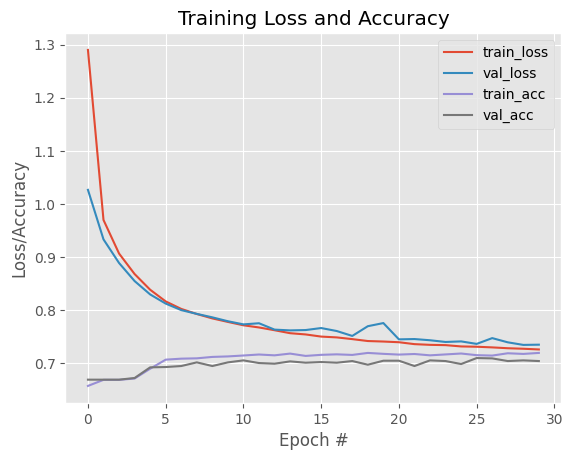

In [89]:
# show accuracy y losses graphs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()